### Import and authentification

In [1]:
import ee 
import folium
from datetime import datetime as dt
from IPython.display import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2

In [2]:
ee.Initialize()
ee.Authenticate()

Enter verification code: 4/1AY0e-g7APB3DOaUxDnpvUT6KbneJEfEkfXdvBcm0hBh4Iik7Ccw5Ph5PmFc

Successfully saved authorization token.


### Global variables

In [3]:
import os
from google.cloud import storage

BUCKET = 'forest_guard_bucket'  # ⚠️ replace with your BUCKET NAME
FOLDER = 'JP_data_forest_guards'
TRAINING_BASE = 'training_patches'
EVAL_BASE = 'eval_patches'

OPTICAL_BANDS = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']
THERMAL_BANDS = ['B10', 'B11']
BANDS = OPTICAL_BANDS + THERMAL_BANDS
RESPONSE = 'fnf'
FEATURES = BANDS + [RESPONSE]

# Specify the size and shape of patches expected by the model.
KERNEL_SIZE = 256
KERNEL_SHAPE = [KERNEL_SIZE, KERNEL_SIZE]

COLUMNS = [
  tf.io.FixedLenFeature(shape=KERNEL_SHAPE, dtype=tf.float32) for k in FEATURES
]
FEATURES_DICT = dict(zip(FEATURES, COLUMNS))

# Specify model training parameters.
#BATCH_SIZE = 16
# EPOCHS = 10
#BUFFER_SIZE = 2000
# OPTIMIZER = 'SGD'
# LOSS = 'MeanSquaredError'
# METRICS = ['RootMeanSquaredError']
   

### Data

#### X

In [4]:
from forest_guard.datas import get_image_landsat

# The image input data is a cloud-masked median composite.
image = get_image_landsat('2015-01-01', '2017-12-31')


# Use folium to visualize the imagery.
mapid = image.getMapId({'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3})
map = folium.Map(location=[48.9, 2.5])
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='median composite',
    opacity = 0.5
  ).add_to(map)

mapid = image.getMapId({'bands': ['B11'], 'min': 0, 'max': 0.5})
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='thermal',
    opacity = 0.5
  ).add_to(map)
map.add_child(folium.LayerControl())
map

#### Target

In [5]:
from forest_guard.datas import get_jaxa
jaxa = get_jaxa('2017-01-01', '2017-12-31')

palette = ['006400',
           'FEFF99',
            '0000FF'
          ]
mapid = jaxa.getMapId({'bands': ['fnf'],
                       'min': 1, 
                       'max': 3, 
                      'palette':palette
                      })
map = folium.Map(location=[48.9, 2.5])


folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='jaxa fnf',
    color=palette,
    opacity = 1
  ).add_to(map)
map.add_child(folium.LayerControl())
map

### Stacking X and y

In [6]:
from forest_guard.datas import get_stacked_arrays

arrays = get_stacked_arrays(image, jaxa, BANDS, RESPONSE, KERNEL_SIZE)

### Areas of interests

In [7]:
# create our own areas of interests
# training features collection
rect_train = ee.Geometry.Rectangle([3.327248985602229, 46.600827791084875, 4.689553673102229,47.70649093701327])
trainingPolys = ee.FeatureCollection([rect_train])
# eval features collections
rect_eval = ee.Geometry.Rectangle([-0.7016469211726672,46.88962161312492, 0.9353159694523328,47.64998631126759])
evalPolys= ee.FeatureCollection([rect_eval])

In [8]:
###################################################
###   DEFINE OUR COLLECTSIONS OF AREAS OF INTEREST
################################################

polyImage = ee.Image(0).byte().paint(trainingPolys, 1).paint(evalPolys, 2)
polyImage = polyImage.updateMask(polyImage)

mapid = polyImage.getMapId({'min': 1, 'max': 2, 'palette': ['red', 'blue']})
map = folium.Map(location=[47., 0.], zoom_start=5)
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='training polygons',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

### Export data TFRecords

In [9]:
from forest_guard.datas import export_to_cloud_sampling_train_eval


export_to_cloud_sampling_train_eval(trainingPolys, evalPolys, arrays, 2, 20, FOLDER)

{'state': 'READY', 'description': 'eval_patches_g0', 'creation_timestamp_ms': 1622040441593, 'update_timestamp_ms': 1622040441593, 'start_timestamp_ms': 0, 'task_type': 'EXPORT_FEATURES', 'id': 'UZHJVYEA66XMCHGCNR2NNWV7', 'name': 'projects/earthengine-legacy/operations/UZHJVYEA66XMCHGCNR2NNWV7'}
Polling for task (id: UZHJVYEA66XMCHGCNR2NNWV7).
Polling for task (id: UZHJVYEA66XMCHGCNR2NNWV7).
Polling for task (id: UZHJVYEA66XMCHGCNR2NNWV7).
Polling for task (id: UZHJVYEA66XMCHGCNR2NNWV7).
Polling for task (id: UZHJVYEA66XMCHGCNR2NNWV7).
{'state': 'COMPLETED', 'description': 'eval_patches_g0', 'creation_timestamp_ms': 1622040441593, 'update_timestamp_ms': 1622040463784, 'start_timestamp_ms': 1622040457167, 'task_type': 'EXPORT_FEATURES', 'destination_uris': ['https://console.developers.google.com/storage/browser/forest_guard_bucket/JP_data_forest_guards/'], 'attempt': 1, 'id': 'UZHJVYEA66XMCHGCNR2NNWV7', 'name': 'projects/earthengine-legacy/operations/UZHJVYEA66XMCHGCNR2NNWV7'}


### Parse TFRecords and get back tensors

In [18]:
from forest_guard.parse import get_training_dataset

training = get_training_dataset(FOLDER)

#print(iter(training.take(1)).next())

#### Data generation

In [4]:
from forest_guard.parse import get_training_dataset_gen

In [5]:
# import warnings
# warnings.filterwarnings('ignore')
training_gen = get_training_dataset_gen(FOLDER)

training_gen

/home/jprezler/.pyenv/versions/3.8.6/envs/forest_guards/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:938: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (20, 256, 256, 9) (9 channels).
  warnings.warn(
/home/jprezler/.pyenv/versions/3.8.6/envs/forest_guards/lib/python3.8/site-packages/keras_preprocessing/image/numpy_array_iterator.py:129: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (20, 256, 256, 9) (9 channels).
  warnings.warn('NumpyArrayIterator is set to use the '


In [6]:
images , labels = next(training_gen)
images.shape, labels.shape

((16, 256, 256, 9), (16, 256, 256, 1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


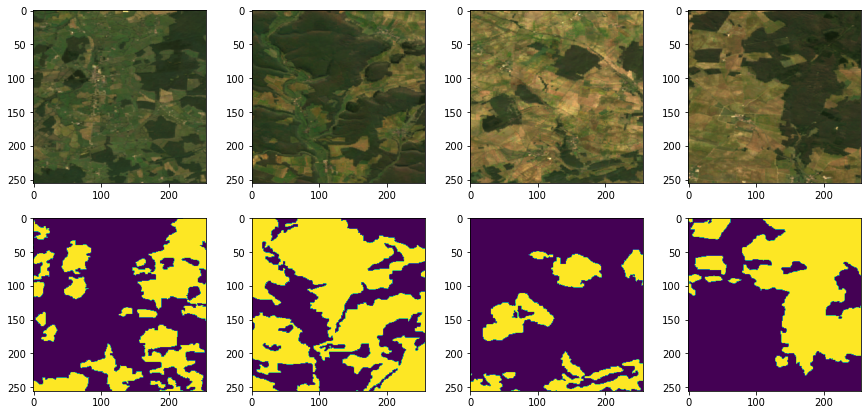

In [7]:
fig, axes = plt.subplots(2,4, figsize=(15,7))
   
for i in range(4):
    axes[0,i].imshow(np.flip(images[i, :, : , 1:4], axis=2)*5)
    axes[1,i].imshow(labels[i, :, : , :])
    

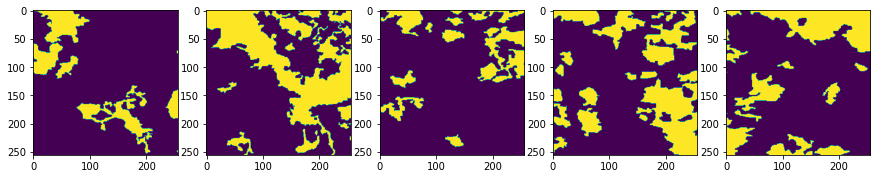

In [17]:
fig = plt.figure(figsize=(15,7))

for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(labels[i, :, : , :])


#### View images

In [31]:
images , labels = iter(training.take(1)).next()

fig = plt.figure(figsize=(15,7))

for i in range(5):
    plt.subplot(1, 5, i+1 )
    plt.imshow(np.flip(images[i, :, : , 1:4].numpy(), axis=2)*5)
    

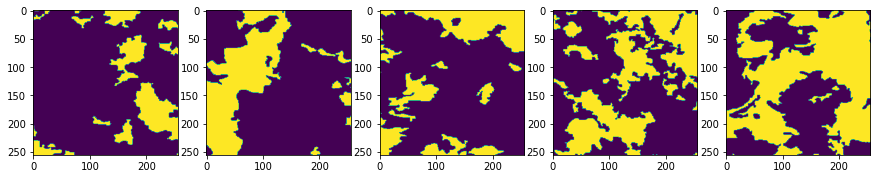

In [33]:
fig = plt.figure(figsize=(15,7))

for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(labels[i, :, : , :])


In [16]:
from forest_guard.parse import get_eval_dataset
evaluation = get_eval_dataset(FOLDER)

In [ ]:
print(iter(evaluation.take(1)).next())

In [9]:

from forest_guard.parse import get_eval_dataset_gen
evaluation_gen = get_eval_dataset_gen(FOLDER)

#### Evaluation augmentation

In [11]:
images , labels = next(evaluation_gen)
images.shape, labels.shape

((1, 256, 256, 9), (1, 256, 256, 1))

### Model

In [10]:
from forest_guard.trainer import Trainer


In [12]:
# train
print('\n', 'instantiate trainer')
trainer = Trainer('test_package')


 instantiate trainer


In [13]:
from tensorflow.keras.metrics import MeanIoU
iou = MeanIoU(num_classes=2)

In [14]:
print('\n', 'download model', '\n')
trainer.download_model_from_gcp()



 download model 



In [20]:

print('\n', 'run trainer', '\n')
history = trainer.run(training, evaluation, 3, metrics = [iou, "mae", "accuracy"], train_size = 160, eval_size=80)



 run trainer 

Epoch 1/3
10/10 [==============================] - ETA: 0s - loss: 0.2979 - mean_io_u: 0.3515 - mae: 0.3240 - accuracy: 0.6852

KeyboardInterrupt: 

In [19]:
# write metrics in ml flow
trainer.metrics_to_mlflow(history)


In [20]:
#save history on the cloud
trainer.save_history(history)

=> history save on cloud storage


In [24]:

# save model

print('\n', 'save model', '\n')
trainer.save_model()

=> history save on cloud storage

 save model 

INFO:tensorflow:Assets written to: gs://forest_guard_bucket/models/forest_guard/test_model/assets


(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

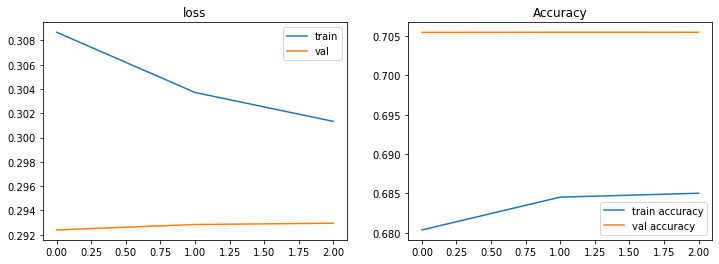

In [19]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)
plot_history(history)